In [1]:
pip install PyMySQL

     |████████████████████████████████| 43 kB 2.8 MB/s             
Note: you may need to restart the kernel to use updated packages.


In [ ]:
conda install -c conda-forge ta-lib

Solving environment: | 
The environment is inconsistent, please check the package plan carefully
The following packages are causing the inconsistency:

  - conda-forge/noarch::nbclient==0.5.2=pyhd8ed1ab_0
  - conda-forge/linux-64::matplotlib==3.3.4=py36h5fab9bb_0
  - conda-forge/noarch::qdarkstyle==2.8.1=pyhd8ed1ab_2
  - conda-forge/linux-64::scikit-image==0.16.2=py36hb3f55d8_0
  - conda-forge/noarch::python-language-server==0.36.2=pyhd8ed1ab_0
  - conda-forge/linux-64::widgetsnbextension==3.5.1=py36h5fab9bb_4
  - conda-forge/noarch::flake8==3.8.4=py_0
  - conda-forge/noarch::ipywidgets==7.6.3=pyhd3deb0d_0
  - conda-forge/noarch::typing-extensions==3.7.4.3=0
  - conda-forge/noarch::path.py==12.5.0=0
  - conda-forge/noarch::dask==2021.2.0=pyhd8ed1ab_0
  - conda-forge/noarch::nbformat==5.1.2=pyhd8ed1ab_1
  - conda-forge/linux-64::path==15.1.2=py36h5fab9bb_0
  - conda-forge/linux-64::nbconvert==6.0.7=py36h5fab9bb_3
  - conda-forge/linux-64::distributed==2021.2.0=py36h5fab9bb_0
  - conda-f

In [1]:
import pymysql
import boto3
import sagemaker
import pandas as pd
import talib
import numpy as np
import json
import time

ONE_GB_IN_BYTES = 1073741824

# Load the interval of 30 Seconds data from AWS TimeStream Database

In [2]:
session = boto3.Session()
query_client = session.client('timestream-query')

In [69]:
# For sagemaker
# get the role of this notebook
role = sagemaker.get_execution_role()
region = boto3.Session().region_name

# the s3 path
bucket = 'capstone-sagemaker-bucket'
prefix = 'timestream-data'

indicator_ndays = 100

# sagemaker session download csv to current path
sm_session = sagemaker.Session()
print(sm_session.default_bucket())

sagemaker-us-east-1-499362316899


In [4]:
class QueryExample:

    def __init__(self, client):
        self.client = client
        self.paginator = client.get_paginator('query')

    

    def run_all_queries(self):
        for query_id in range(len(self.queries)):
            print("Running query [%d] : [%s]" % (query_id + 1, self.queries[query_id]))
            self.run_query(self.queries[query_id])

    def run_query(self, query_string):
        result_df = ""
        try:
            page_iterator = self.paginator.paginate(QueryString=query_string)

            for page in page_iterator:
                result_df = self._parse_query_result(page)
        except Exception as err:
            print("Exception while running query:", err)
        
        return result_df

    def _parse_query_result(self, query_result):
        query_status = query_result["QueryStatus"]

        progress_percentage = query_status["ProgressPercentage"]
        print(f"Query progress so far: {progress_percentage}%")

        bytes_scanned = float(query_status["CumulativeBytesScanned"]) / ONE_GB_IN_BYTES
        print(f"Data scanned so far: {bytes_scanned} GB")

        bytes_metered = float(query_status["CumulativeBytesMetered"]) / ONE_GB_IN_BYTES
        print(f"Data metered so far: {bytes_metered} GB")

        column_info = query_result['ColumnInfo']

        print("Metadata: %s" % column_info)
        print("Data: ")
        
        data_arr = []
        for row in query_result['Rows']:
            parsed = self._parse_row(column_info, row)
            data_arr.append(row['Data'])
            print(parsed)
        
        a_df = self._to_pandas_df(data_arr)
        #print(a_df)
        return a_df
    
    def _to_pandas_df(self, arr):
        x_arr = []
        for x in arr:
            i_arr = []
            for i in x:
                i_arr.append(i['ScalarValue'])
            x_arr.append(i_arr)

        return pd.DataFrame(x_arr, columns=['symbol', 'close', 'avg_close', 'min_close', 'max_close', 'binned_timestamp'])

    def _parse_row(self, column_info, row):
        data = row['Data']
        row_output = []
        for j in range(len(data)):
            info = column_info[j]
            datum = data[j]
            row_output.append(self._parse_datum(info, datum))

        return "{%s}" % str(row_output)

    def _parse_datum(self, info, datum):
        if datum.get('NullValue', False):
            return "%s=NULL" % info['Name'],

        column_type = info['Type']

        # If the column is of TimeSeries Type
        if 'TimeSeriesMeasureValueColumnInfo' in column_type:
            return self._parse_time_series(info, datum)

        # If the column is of Array Type
        elif 'ArrayColumnInfo' in column_type:
            array_values = datum['ArrayValue']
            return "%s=%s" % (info['Name'], self._parse_array(info['Type']['ArrayColumnInfo'], array_values))

        # If the column is of Row Type
        elif 'RowColumnInfo' in column_type:
            row_column_info = info['Type']['RowColumnInfo']
            row_values = datum['RowValue']
            return self._parse_row(row_column_info, row_values)

        # If the column is of Scalar Type
        else:
            return self._parse_column_name(info) + datum['ScalarValue']

    def _parse_time_series(self, info, datum):
        time_series_output = []
        for data_point in datum['TimeSeriesValue']:
            time_series_output.append("{time=%s, value=%s}"
                                      % (data_point['Time'],
                                         self._parse_datum(info['Type']['TimeSeriesMeasureValueColumnInfo'],
                                                           data_point['Value'])))
        return "[%s]" % str(time_series_output)

    def _parse_array(self, array_column_info, array_values):
        array_output = []
        for datum in array_values:
            array_output.append(self._parse_datum(array_column_info, datum))

        return "[%s]" % str(array_output)

    def run_query_with_multiple_pages(self, limit):
        query_with_limit = self.SELECT_ALL + " LIMIT " + str(limit)
        print("Starting query with multiple pages : " + query_with_limit)
        self.run_query(query_with_limit)

    def cancel_query(self):
        print("Starting query: " + self.SELECT_ALL)
        result = self.client.query(QueryString=self.SELECT_ALL)
        print("Cancelling query: " + self.SELECT_ALL)
        try:
            self.client.cancel_query(QueryId=result['QueryId'])
            print("Query has been successfully cancelled")
        except Exception as err:
            print("Cancelling query failed:", err)

    @staticmethod
    def _parse_column_name(info):
        if 'Name' in info:
            return info['Name'] + "="
        else:
            return ""

In [5]:
QUERY_1 = f"""
        SELECT
            symbol, measure_name,
            ROUND(AVG(measure_value::double), 2) AS avg_close,
            ROUND(min(measure_value::double), 2) as min_close,
            ROUND(max(measure_value::double), 2) as max_close,
            BIN(time, 30s) AS binned_timestamp
        FROM "realTimeDB"."indexTable"
        where "symbol" = 'OANDA:NAS100_USD' 
        and "measure_name" = 'close'
        GROUP BY symbol, measure_name, BIN(time, 30s)
        ORDER BY binned_timestamp ASC
        """

# Load Data

In [6]:
query_example = QueryExample(query_client)
nasdaq_df = query_example.run_query(QUERY_1)

Query progress so far: 100.0%
Data scanned so far: 8.485931903123856e-05 GB
Data metered so far: 0.009313225746154785 GB
Metadata: [{'Name': 'symbol', 'Type': {'ScalarType': 'VARCHAR'}}, {'Name': 'measure_name', 'Type': {'ScalarType': 'VARCHAR'}}, {'Name': 'avg_close', 'Type': {'ScalarType': 'DOUBLE'}}, {'Name': 'min_close', 'Type': {'ScalarType': 'DOUBLE'}}, {'Name': 'max_close', 'Type': {'ScalarType': 'DOUBLE'}}, {'Name': 'binned_timestamp', 'Type': {'ScalarType': 'TIMESTAMP'}}]
Data: 
{['symbol=OANDA:NAS100_USD', 'measure_name=close', 'avg_close=13771.99', 'min_close=13771.99', 'max_close=13771.99', 'binned_timestamp=2022-04-22 12:31:30.000000000']}
{['symbol=OANDA:NAS100_USD', 'measure_name=close', 'avg_close=13769.28', 'min_close=13768.68', 'max_close=13770.02', 'binned_timestamp=2022-04-22 12:32:00.000000000']}
{['symbol=OANDA:NAS100_USD', 'measure_name=close', 'avg_close=13764.83', 'min_close=13763.59', 'max_close=13766.07', 'binned_timestamp=2022-04-22 12:32:30.000000000']}
{['

In [7]:
nasdaq_df_copy = nasdaq_df.copy()
nasdaq_df_copy['TDate'] = pd.to_datetime(nasdaq_df_copy.binned_timestamp)
nasdaq_df_copy['TDate'] +=  pd.to_timedelta(-4, unit='h')
nasdaq_df_copy.iloc[7:,:]

,symbol,close,avg_close,min_close,max_close,binned_timestamp,TDate
7,OANDA:NAS100_USD,close,13723.54,13721.74,13725.33,2022-04-22 13:30:00.000000000,2022-04-22 09:30:00
8,OANDA:NAS100_USD,close,13732.25,13726.3,13736.14,2022-04-22 13:30:30.000000000,2022-04-22 09:30:30
9,OANDA:NAS100_USD,close,13743.06,13741.28,13744.14,2022-04-22 13:31:00.000000000,2022-04-22 09:31:00
10,OANDA:NAS100_USD,close,13739.48,13735.38,13744.83,2022-04-22 13:31:30.000000000,2022-04-22 09:31:30
11,OANDA:NAS100_USD,close,13729.28,13718.53,13739.44,2022-04-22 13:32:00.000000000,2022-04-22 09:32:00
...,...,...,...,...,...,...,...
763,OANDA:NAS100_USD,close,13373.03,13369.89,13375.69,2022-04-22 19:57:30.000000000,2022-04-22 15:57:30
764,OANDA:NAS100_USD,close,13371.32,13367.07,13373.57,2022-04-22 19:58:00.000000000,2022-04-22 15:58:00
765,OANDA:NAS100_USD,close,13367.0,13365.5,13368.02,2022-04-22 19:58:30.000000000,2022-04-22 15:58:30
766,OANDA:NAS100_USD,close,13357.3,13353.16,13361.01,2022-04-22 19:59:00.000000000,2022-04-22 15:59:00


In [8]:
nasdaq_data_df = nasdaq_df_copy.iloc[7:,:]
nasdaq_data_df = nasdaq_data_df[['avg_close', 'min_close', 'max_close', 'TDate']]
nasdaq_data_df.rename(columns={'avg_close':'close', 'min_close':'low', 'max_close':'high', 'TDate':'trade_date'}, inplace = True)
nasdaq_data_df.head(3)

,close,low,high,trade_date
7,13723.54,13721.74,13725.33,2022-04-22 09:30:00
8,13732.25,13726.3,13736.14,2022-04-22 09:30:30
9,13743.06,13741.28,13744.14,2022-04-22 09:31:00


In [9]:
nasdaq_data_df = nasdaq_data_df.astype({'close': 'float','low': 'float','high': 'float'})

In [10]:
nasdaq_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 761 entries, 7 to 767
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   close       761 non-null    float64       
 1   low         761 non-null    float64       
 2   high        761 non-null    float64       
 3   trade_date  761 non-null    datetime64[ns]
dtypes: datetime64[ns](1), float64(3)
memory usage: 23.9 KB


# Selected Technical Indicators 

- n: For example n = 10

- 1. Simple n-day moving average = (𝐶t + ... 𝐶t-n+1) / n
- 2. Weighted n-day moving average = (𝑛∗𝐶𝑡+(𝑛−1)∗𝐶𝑡−1+⋯+𝐶𝑡−𝑛+1) / (𝑛+(𝑛−1)+⋯+1)
- 3. Relative strength index (RSI) = https://school.stockcharts.com/doku.php?id=technical_indicators:relative_strength_index_rsi
- 4. Commodity Channel Index = https://school.stockcharts.com/doku.php?id=technical_indicators:commodity_channel_index_cci
- 5. Rate of Change (ROC) = https://school.stockcharts.com/doku.php?id=technical_indicators:rate_of_change_roc_and_momentum
- 6. Bollinger Bands = https://school.stockcharts.com/doku.php?id=technical_indicators:bollinger_bands
- 7. Momentum = 𝐶𝑡 − 𝐶𝑡−𝑛+1

𝐶𝑡 is the closing price at time t

open(t) is the opening price at time t

v(t) is the volume at time t

In [11]:
# Simple Moving Average
# https://school.stockcharts.com/doku.php?id=technical_indicators:moving_averages
def SMA(data, ndays):
    SMA = pd.Series(data['close'].rolling(ndays, min_periods = 1).mean(), name = 'sma_' + str(ndays))
    data = data.join(SMA)
    return data

# Weighted n-day moving average
def WMA(data, ndays):
    name = 'wma_' + str(ndays)
    data[name] = talib.RSI(data['close'], timeperiod=ndays)
    return data

# Relative strength index (RSI)
def RSI(data, ndays):
    name = 'rsi_' + str(ndays)
    data[name] = talib.RSI(data['close'], timeperiod=ndays)
    return data


# Commodity Channel Index
def CCI(data, ndays):
    name = 'cci_' + str(ndays)
    data[name] = talib.CCI(data['high'], data['low'], data['close'], timeperiod=ndays)
    return data

# Rate of Change (ROC)
def ROC(data, ndays):
    name = 'roc_' + str(ndays)
    data[name] = talib.ROC(data['close'], timeperiod=ndays)
    return data

# Bollinger Bands
def BollingerBands(data, ndays, col_name='close'):
    MA = data[col_name].rolling(ndays, min_periods = 1).mean()
    SD = data[col_name].rolling(ndays, min_periods = 1).std()
    
    b1 = MA + (2 * SD)
    B1 = pd.Series(b1, name = 'bband_upper_' + str(ndays))
    data = data.join(B1)
    
    b2 = MA - (2 * SD)
    B2 = pd.Series(b2, name = 'bband_lower_' + str(ndays))
    data = data.join(B2) 
    return data

def Momentum(data, ndays):
    name = 'mom_' + str(ndays)
    data[name] = talib.MOM(data['close'], timeperiod=ndays)
    return data


def add_indicators(data, ndays = 10):
    data = SMA(data, ndays)
    data = WMA(data, ndays)
    data = RSI(data, ndays)
    data = CCI(data, ndays)
    data = ROC(data, ndays)
    data = BollingerBands(data, ndays)
    data = Momentum(data, ndays)
    
    return data

In [12]:
def indicator_names(ndays):
    arr = ['trade_date', 'close', 'high', 'low',
           'sma_' + str(ndays), 'wma_' + str(ndays), 'rsi_' + str(ndays),
           'cci_' + str(ndays), 'roc_' + str(ndays), 
           'bband_upper_' + str(ndays), 'bband_lower_' + str(ndays), 'mom_' + str(ndays)]

    return arr
    
def get_model_df(data, ndays):
    df_ = add_indicators(data, ndays)
    df_ = df_.iloc[ndays:, :]
    print(df_.shape)
    return df_[indicator_names(ndays)]

def df_cols_to_obj(data_df, target_col_name, dynamic_feat_cols):
    d_feats = []
    for f in dynamic_feat_cols:
        d_feats.append(list(data_df[f]))
        
    obj = {"start": str(data_df.index[0]), 
           "target": list(data_df[target_col_name]),
           "dynamic_feat":d_feats}
    
    return json.dumps(obj)

def save_json_to_s3(indicator_ndays, X_deepAR_train, X_deepAR_test):
    encoding = "utf-8"
    FILE_TRAIN = "train.json"
    FILE_TEST = "test.json"
    target_col_name = "close"

    with open(FILE_TRAIN, "wb") as f:
        obj_ = df_cols_to_obj(X_deepAR_train, target_col_name, dynamic_feat_cols)
        f.write(obj_.encode(encoding))
        f.write("\n".encode(encoding))

    with open(FILE_TEST, "wb") as f:
        obj_ = df_cols_to_obj(X_deepAR_test, target_col_name, dynamic_feat_cols)
        f.write(obj_.encode(encoding))
        f.write("\n".encode(encoding))

    s3 = boto3.client("s3")
    s3.upload_file(FILE_TRAIN, bucket, prefix + "/data/train/{}/".format(str(indicator_ndays)) + FILE_TRAIN)
    s3.upload_file(FILE_TEST, bucket, prefix + "/data/test/{}/".format(str(indicator_ndays)) + FILE_TRAIN)

def save_json_for_deepAR(data_df, ndays):
        
    # add indicators
    amd_df = get_model_df(data_df, ndays)

    # get train set rows
    training_data_len = int(np.ceil( len(amd_df) * .8 ))
    print("train_length:{}, test_length:{}".format(training_data_len, len(amd_df) - training_data_len))

    X_deepAR_close = amd_df.copy()

    X_deepAR_close.set_index('trade_date', inplace=True)

    # train set
    X_deepAR_train = X_deepAR_close[:training_data_len]

    # test set contains the full range of each time series.
    X_deepAR_test = X_deepAR_close[:]

    # save json of train and test into s3. s3://capstone-sagemaker-bucket/xgb-data/data/train/10/train.json
    save_json_to_s3(ndays, X_deepAR_train, X_deepAR_test)
    
    return X_deepAR_train, X_deepAR_test, training_data_len

In [70]:
# get all indicators
all_indicator_names = indicator_names(indicator_ndays)
dynamic_feat_cols = all_indicator_names[2:]
print(dynamic_feat_cols)

['high', 'low', 'sma_100', 'wma_100', 'rsi_100', 'cci_100', 'roc_100', 'bband_upper_100', 'bband_lower_100', 'mom_100']


# Save json files into s3

In [71]:
X_deepAR_train, X_deepAR_test, training_data_len = save_json_for_deepAR(nasdaq_data_df.copy(), indicator_ndays)

(661, 12)
train_length:529, test_length:132


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/boto3/compat.py:88: PythonDeprecationWarning: Boto3 will no longer support Python 3.6 starting May 30, 2022. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.7 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
  warnings.warn(warning, PythonDeprecationWarning)


# Train a model

In [15]:
image_uri = sagemaker.image_uris.retrieve("forecasting-deepar", boto3.Session().region_name)
sagemaker_session = sm_session

In [16]:
def fit_model(indicator_ndays, X_deepAR_close, training_data_len):
    
    s3_data_path = f"{bucket}/{prefix}/data"
    s3_output_path = f"{bucket}/{prefix}/output/{str(indicator_ndays)}/"

    deepar_estimator = sagemaker.estimator.Estimator(
        sagemaker_session=sagemaker_session,
        image_uri=image_uri,
        role=role,
        instance_count=1,
        instance_type="ml.c4.xlarge",
        base_job_name="aapl-deepar",
        output_path=f"s3://{s3_output_path}",
    )
    
    freq = "D"
    context_length = X_deepAR_close.shape[0]
    print(context_length)

    prediction_length = X_deepAR_close.shape[0] - training_data_len
    print(prediction_length)

    hyperparameters = {
        "time_freq": freq,
        "context_length": str(prediction_length),
        "prediction_length": str(prediction_length),
        "num_cells": "40",
        "num_layers": "3",
        "likelihood": "gaussian",
        "epochs": "20",
        "mini_batch_size": "32",
        "learning_rate": "0.001",
        "dropout_rate": "0.05",
        "early_stopping_patience": "10",
        "num_dynamic_feat": "auto",  # this will use the `dynamic_feat` field if it's present in the data
    }
    
    deepar_estimator.set_hyperparameters(**hyperparameters)
    
    
    data_channels = {"train": f"s3://{s3_data_path}/train/{str(indicator_ndays)}/", 
                     "test": f"s3://{s3_data_path}/test/{str(indicator_ndays)}/"}

    deepar_estimator.fit(inputs=data_channels)
    
    return deepar_estimator


def train_model(data_df, indicator_ndays):
    
    # add indicators
    amd_df = get_model_df(data_df, indicator_ndays)

    # get train set rows
    training_data_len = int(np.ceil( len(amd_df) * .8 ))
    print("train_length:{}, test_length:{}".format(training_data_len, len(amd_df) - training_data_len))

    X_deepAR_close = amd_df.copy()

    deepar_estimator = fit_model(indicator_ndays, X_deepAR_close, training_data_len)
    
    return deepar_estimator

### Train models with different ndays (10, 20, 50, 100)

In [72]:
stock_df = nasdaq_data_df.copy()

In [18]:
# 10, 20, 50, 100 days
print("Train a model with {} days for indicators".format(str(indicator_ndays)))
deepar_estimator_model = train_model(stock_df.copy(), indicator_ndays)

Train a model with 10 days for indicators
(751, 12)
train_length:601, test_length:150
751
150
2022-04-30 01:19:45 Starting - Starting the training job...
2022-04-30 01:20:12 Starting - Preparing the instances for trainingProfilerReport-1651281585: InProgress
.........
2022-04-30 01:21:40 Downloading - Downloading input data......
2022-04-30 01:22:47 Training - Training image download completed. Training in progress..Arguments: train
[04/30/2022 01:22:53 INFO 140603287061888 integration.py:592] worker started
[04/30/2022 01:22:53 INFO 140603287061888] Reading default configuration from /opt/amazon/lib/python3.6/site-packages/algorithm/resources/default-input.json: {'_kvstore': 'auto', '_num_gpus': 'auto', '_num_kv_servers': 'auto', '_tuning_objective_metric': '', 'cardinality': 'auto', 'dropout_rate': '0.10', 'early_stopping_patience': '', 'embedding_dimension': '10', 'learning_rate': '0.001', 'likelihood': 'student-t', 'mini_batch_size': '128', 'num_cells': '40', 'num_dynamic_feat': 'a

In [40]:
# 20
print("Train a model with {} days for indicators".format(str(indicator_ndays)))
deepar_estimator_model = train_model(stock_df.copy(), indicator_ndays)

Train a model with 20 days for indicators
(741, 12)
train_length:593, test_length:148
741
148
2022-04-30 01:35:14 Starting - Starting the training job...
2022-04-30 01:35:42 Starting - Preparing the instances for trainingProfilerReport-1651282514: InProgress
.........
2022-04-30 01:37:14 Downloading - Downloading input data
2022-04-30 01:37:14 Training - Downloading the training image........Arguments: train
[04/30/2022 01:38:25 INFO 140201960785280 integration.py:592] worker started
[04/30/2022 01:38:25 INFO 140201960785280] Reading default configuration from /opt/amazon/lib/python3.6/site-packages/algorithm/resources/default-input.json: {'_kvstore': 'auto', '_num_gpus': 'auto', '_num_kv_servers': 'auto', '_tuning_objective_metric': '', 'cardinality': 'auto', 'dropout_rate': '0.10', 'early_stopping_patience': '', 'embedding_dimension': '10', 'learning_rate': '0.001', 'likelihood': 'student-t', 'mini_batch_size': '128', 'num_cells': '40', 'num_dynamic_feat': 'auto', 'num_eval_samples':

In [56]:
# 50
print("Train a model with {} days for indicators".format(str(indicator_ndays)))
deepar_estimator_model = train_model(stock_df.copy(), indicator_ndays)

Train a model with 50 days for indicators
(711, 12)
train_length:569, test_length:142
711
142
2022-04-30 01:49:47 Starting - Starting the training job...
2022-04-30 01:50:13 Starting - Preparing the instances for trainingProfilerReport-1651283386: InProgress
.........
2022-04-30 01:51:33 Downloading - Downloading input data...
2022-04-30 01:52:13 Training - Downloading the training image...
2022-04-30 01:52:44 Training - Training image download completed. Training in progress..Arguments: train
[04/30/2022 01:52:50 INFO 140509821412736 integration.py:592] worker started
[04/30/2022 01:52:50 INFO 140509821412736] Reading default configuration from /opt/amazon/lib/python3.6/site-packages/algorithm/resources/default-input.json: {'_kvstore': 'auto', '_num_gpus': 'auto', '_num_kv_servers': 'auto', '_tuning_objective_metric': '', 'cardinality': 'auto', 'dropout_rate': '0.10', 'early_stopping_patience': '', 'embedding_dimension': '10', 'learning_rate': '0.001', 'likelihood': 'student-t', 'mini

In [73]:
# 100
print("Train a model with {} days for indicators".format(str(indicator_ndays)))
deepar_estimator_model = train_model(stock_df.copy(), indicator_ndays)

Train a model with 100 days for indicators
(661, 12)
train_length:529, test_length:132
661
132
2022-04-30 02:04:29 Starting - Starting the training job...
2022-04-30 02:04:53 Starting - Preparing the instances for trainingProfilerReport-1651284269: InProgress
.........
2022-04-30 02:06:18 Downloading - Downloading input data...
2022-04-30 02:06:54 Training - Downloading the training image...
2022-04-30 02:07:29 Training - Training image download completed. Training in progress...Arguments: train
[04/30/2022 02:07:35 INFO 140157067654528 integration.py:592] worker started
[04/30/2022 02:07:35 INFO 140157067654528] Reading default configuration from /opt/amazon/lib/python3.6/site-packages/algorithm/resources/default-input.json: {'_kvstore': 'auto', '_num_gpus': 'auto', '_num_kv_servers': 'auto', '_tuning_objective_metric': '', 'cardinality': 'auto', 'dropout_rate': '0.10', 'early_stopping_patience': '', 'embedding_dimension': '10', 'learning_rate': '0.001', 'likelihood': 'student-t', 'mi

### Deploy an endpoint

In [74]:
# Create endpoint and predictor
# Note: remember to delete the endpoint after running this experiment. 
# A cell at the very bottom of this notebook will do that: make sure you run it at the end.

job_name = deepar_estimator_model.latest_training_job.name
print("job_name = {}".format(job_name))

#image_uri = sagemaker.image_uris.retrieve("forecasting-deepar", boto3.Session().region_name)

endpoint_name = sm_session.endpoint_from_job(
    job_name=job_name,
    initial_instance_count=1,
    instance_type="ml.m4.xlarge",
    image_uri=image_uri,
    role=role,
)

job_name = aapl-deepar-2022-04-30-02-04-29-536
----------!

# Make predictions and plot results

In [20]:
freq = "min"
target_col_name = "close"

In [21]:
class DeepARPredictor(sagemaker.predictor.RealTimePredictor):
    def set_prediction_parameters(self, freq, prediction_length):
        """Set the time frequency and prediction length parameters. This method **must** be called
        before being able to use `predict`.

        Parameters:
        freq -- string indicating the time frequency
        prediction_length -- integer, number of predicted time points

        Return value: none.
        """
        self.freq = freq
        self.prediction_length = prediction_length

    def predict(
        self,
        ts,
        cat=None,
        dynamic_feat=None,
        encoding="utf-8",
        num_samples=100,
        quantiles=["0.1", "0.5", "0.9"],
        content_type="application/json",
    ):
        """Requests the prediction of for the time series listed in `ts`, each with the (optional)
        corresponding category listed in `cat`.

        Parameters:
        ts -- list of `pandas.Series` objects, the time series to predict
        cat -- list of integers (default: None)
        encoding -- string, encoding to use for the request (default: "utf-8")
        num_samples -- integer, number of samples to compute at prediction time (default: 100)
        quantiles -- list of strings specifying the quantiles to compute (default: ["0.1", "0.5", "0.9"])

        Return value: list of `pandas.DataFrame` objects, each containing the predictions
        """
        prediction_times = [x.index[-1] + pd.Timedelta(1, unit=self.freq) for x in ts]
        req = self.__encode_request(ts, cat, dynamic_feat, encoding, num_samples, quantiles)
        res = super(DeepARPredictor, self).predict(req, initial_args={"ContentType": content_type})
        return self.__decode_response(res, prediction_times, encoding)

    def __encode_request(self, ts, cat, dynamic_feat, encoding, num_samples, quantiles):
        instances = [series_to_obj(ts[k], cat[k] if cat else None, dynamic_feat[k] if dynamic_feat else None) for k in range(len(ts))]
        configuration = {
            "num_samples": num_samples,
            "output_types": ["quantiles"],
            "quantiles": quantiles,
        }
        http_request_data = {"instances": instances, "configuration": configuration}
        return json.dumps(http_request_data).encode(encoding)

    def __decode_response(self, response, prediction_times, encoding):
        response_data = json.loads(response.decode(encoding))
        list_of_df = []
        for k in range(len(prediction_times)):
            prediction_index = pd.date_range(
                start=prediction_times[k], freq=self.freq, periods=self.prediction_length
            )
            list_of_df.append(
                pd.DataFrame(
                    data=response_data["predictions"][k]["quantiles"], index=prediction_index
                )
            )
        return list_of_df

def series_to_obj(ts, cat=None, dynamic_feat=None):
    obj = {"start": str(ts.index[0]), "target": list(ts)}
    if cat is not None:
        obj["cat"] = cat
    if dynamic_feat is not None:
        obj["dynamic_feat"] = dynamic_feat
    return obj


def series_to_jsonline(ts, cat=None):
    return json.dumps(series_to_obj(ts, cat))

In [75]:
prediction_length = X_deepAR_test.shape[0] - X_deepAR_train.shape[0]
prediction_length

132

In [76]:
predictor = DeepARPredictor(endpoint_name=endpoint_name, sagemaker_session=sm_session)
predictor.set_prediction_parameters(freq, prediction_length)

The class RealTimePredictor has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


### Use train set to predict

In [77]:
time_series = []
index = pd.date_range(start=X_deepAR_train.index[0], freq=freq, periods=X_deepAR_train.shape[0])
time_series.append(pd.Series(data=X_deepAR_train['close'].to_numpy(), index=index))

In [78]:
d_feats = []
for f in dynamic_feat_cols:
    d_feats.append(list(X_deepAR_test[f]))

In [79]:
len(d_feats[0])

661

In [80]:
d_feats_arr = [d_feats]

### Predict [10, 20, 50, 100] different number of samples to compute at prediction time

In [81]:
back_samples = [10, 20, 50, 100]
def predict_diff_back_view_samples():
    
    
    results = []
    results_list_of_df = []
    for num_samples in back_samples:
        list_of_df_ = predictor.predict(ts=time_series[:1], cat=None, dynamic_feat=d_feats_arr, 
                               num_samples = num_samples, content_type="application/json")
        
        # get RMSE
        rmse_= np.sqrt(np.mean(np.power((X_deepAR_test['close'][-prediction_length:].values - list_of_df_[0]["0.5"].values), 2)))
        
        # get earn pct
        earn_pct_ = cal_earn_pct(X_deepAR_test['close'][-prediction_length:].values, list_of_df_[0]["0.5"].values)
        
        re_dict = {"indicator_days":indicator_ndays, "back_view_samples":num_samples, "rmse":rmse_, "earn_pct":earn_pct_}

        results.append(re_dict)
        
        results_list_of_df.append(list_of_df_)
        
    return results, results_list_of_df

# real_closes is np.array, predicted_closes is np.array
def cal_earn_pct(real_closes, predicted_closes):
    real_closes_df = pd.DataFrame(real_closes, columns=['real_close'])
    p_closes_df = pd.DataFrame(predicted_closes, columns=['close'])
    
    predicted_closes_df = pd.concat([real_closes_df,p_closes_df], axis=1)
    
    start_cash = 1000000
    
    init_cash = 1000000
    hold_number_stocks = 0
    
    symbol = 'income'
    bought = {symbol:'OUT'}
    trade_lst = []
    sold_lst = []
    # amd_df['direction'] = np.sign(amd_df["close"].pct_change()*100.0)
    # predicted_closes_df = pd.DataFrame([predicted_closes], columns=['close'])
    
    
    predicted_closes_df['predict_direction'] = np.sign(predicted_closes_df["close"].pct_change()*100.0)
    
    for index, row in predicted_closes_df.iterrows():
        
        change_pct = 0.0
        if trade_lst:
            last_one = trade_lst[-1]
            
            change_pct = (row['real_close'] / last_one[0] - 1) * 100
                
        if row['predict_direction'] > 0.0 and bought[symbol] == 'OUT':
            
            trade_lst.append(row)
            
            number_stocks = init_cash // row['real_close']
            hold_number_stocks = number_stocks

            spend = number_stocks * row['real_close']
            #print(init_cash)
            init_cash -= spend


            bought[symbol] = 'LONG'
            continue
            
        elif bought[symbol] == 'LONG' and ( (row['predict_direction'] < 0.0) or change_pct > 1.0 or change_pct < -1.0 ):
            sold_lst.append(row)

            sold = hold_number_stocks * row['real_close']
            #print('sold:' + str(sold))
            #print('init_cash:' + str(init_cash))
            init_cash += sold
            #print('---' + str(init_cash))

            hold_number_stocks = 0
            bought[symbol] = 'OUT'
            continue

    
    cash = init_cash + hold_number_stocks * trade_lst[-1][0]
    #print(cash)
    earn_pct = (cash / start_cash - 1) * 100
    #print(earn_pct)
    return round(earn_pct, 2)

predict_results, results_list_of_df = predict_diff_back_view_samples()

In [29]:
indicator_10_result = pd.DataFrame(predict_results)
indicator_10_result

,indicator_days,back_view_samples,rmse,earn_pct
0,10,10,106.461947,-0.31
1,10,20,92.394470,-0.94
2,10,50,88.429475,-0.38
3,10,100,84.770107,-0.28


In [49]:
indicator_20_result = pd.DataFrame(predict_results)
indicator_20_result

,indicator_days,back_view_samples,rmse,earn_pct
0,20,10,99.353221,-0.13
1,20,20,80.913658,-0.48
2,20,50,73.279505,-0.25
3,20,100,69.162140,-0.41


In [65]:
indicator_50_result = pd.DataFrame(predict_results)
indicator_50_result

,indicator_days,back_view_samples,rmse,earn_pct
0,50,10,114.754316,-0.40
1,50,20,120.360590,-0.47
2,50,50,128.728532,-0.38
3,50,100,123.507391,-0.47


In [82]:
indicator_100_result = pd.DataFrame(predict_results)
indicator_100_result

,indicator_days,back_view_samples,rmse,earn_pct
0,100,10,91.984815,-0.54
1,100,20,78.598411,-0.28
2,100,50,76.087845,0.06
3,100,100,72.608763,0.22


In [83]:
all_ind_results = pd.concat([indicator_10_result, indicator_20_result, indicator_50_result, indicator_100_result])
all_ind_results.sort_values(by=['rmse'])

,indicator_days,back_view_samples,rmse,earn_pct
3,20,100,69.162140,-0.41
3,100,100,72.608763,0.22
2,20,50,73.279505,-0.25
2,100,50,76.087845,0.06
1,100,20,78.598411,-0.28
1,20,20,80.913658,-0.48
3,10,100,84.770107,-0.28
2,10,50,88.429475,-0.38
0,100,10,91.984815,-0.54
1,10,20,92.394470,-0.94


In [84]:
all_ind_results.sort_values(by=['earn_pct'], ascending=False)

,indicator_days,back_view_samples,rmse,earn_pct
3,100,100,72.608763,0.22
2,100,50,76.087845,0.06
0,20,10,99.353221,-0.13
2,20,50,73.279505,-0.25
3,10,100,84.770107,-0.28
1,100,20,78.598411,-0.28
0,10,10,106.461947,-0.31
2,10,50,88.429475,-0.38
2,50,50,128.728532,-0.38
0,50,10,114.754316,-0.40


### View the predictions

In [30]:
# Prepar data set for plots
actual_data_time_series = []
index = X_deepAR_test.index
actual_data_time_series.append(pd.Series(data=X_deepAR_test['close'].to_numpy(), index=index))

In [31]:
import matplotlib.pyplot as plt

In [32]:
def draw_line():
    for k in range(len(results_list_of_df)):
        plt.figure(figsize=(12, 6))
        #actual_data_time_series[k][- context_length :].plot(label="target")
        actual_data_time_series[0][- prediction_length :].plot(label="target")
        p10 = results_list_of_df[k][0]["0.1"]
        p90 = results_list_of_df[k][0]["0.9"]
        plt.fill_between(actual_data_time_series[0][- prediction_length :].index, p10, p90, color="y", alpha=0.5, label="80% confidence interval")
        p50 = pd.Series(data=results_list_of_df[k][0]["0.5"].to_numpy(), index=actual_data_time_series[0][- prediction_length :].index)
        p50.plot(label="prediction median")
        plt.legend()
        plt.title("Indicators = {}, Back view samples = {}".format(str(indicator_ndays), str(back_samples[k])))
        plt.show()

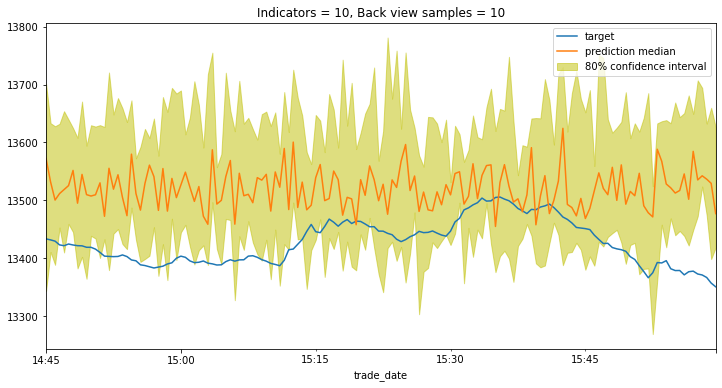

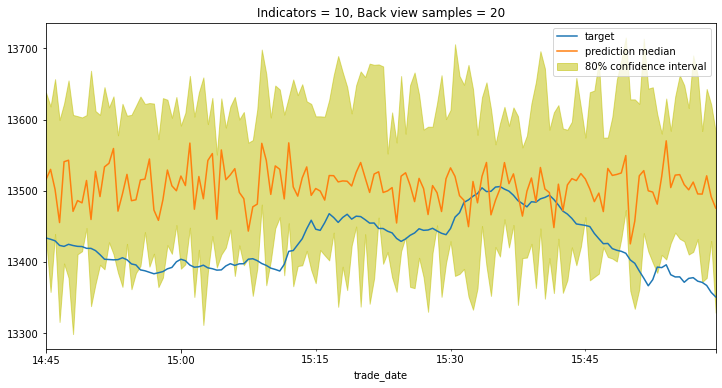

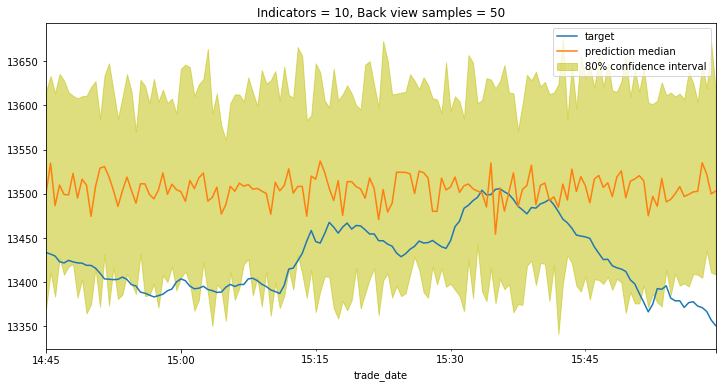

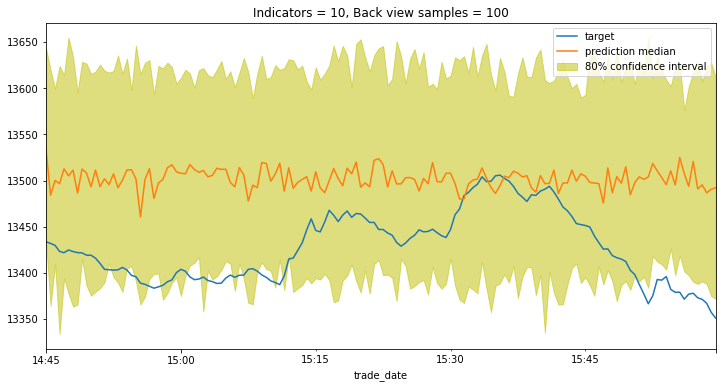

In [33]:
# 10
draw_line()

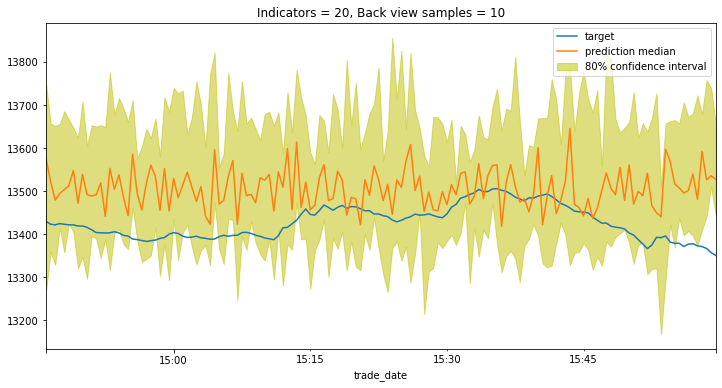

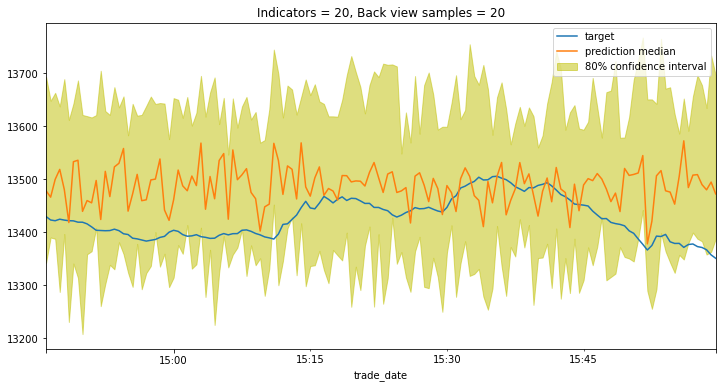

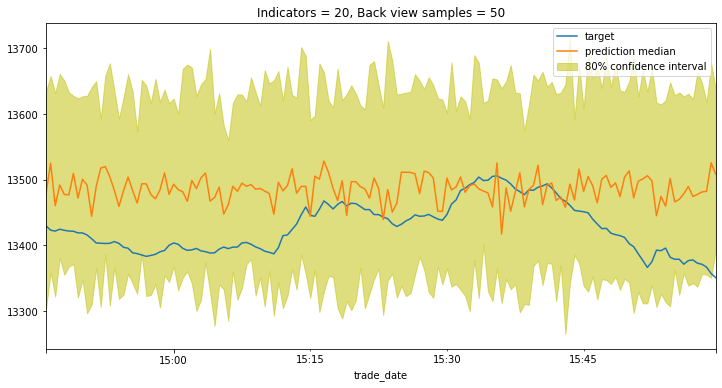

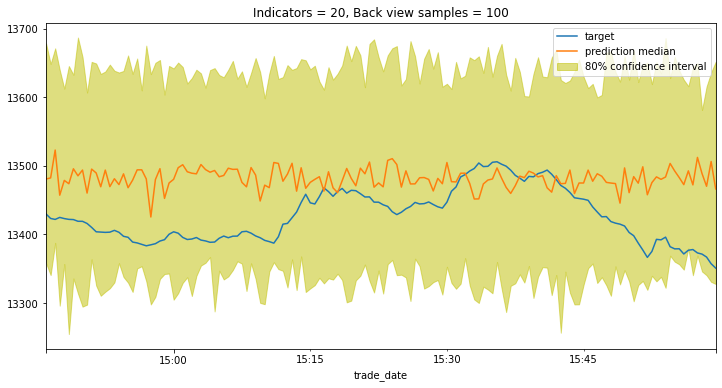

In [50]:
# 20
draw_line()

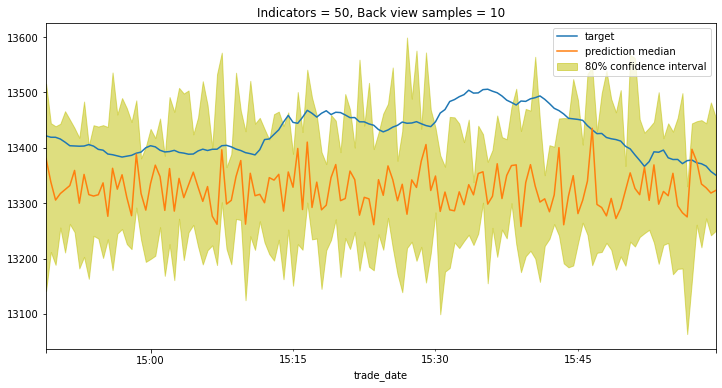

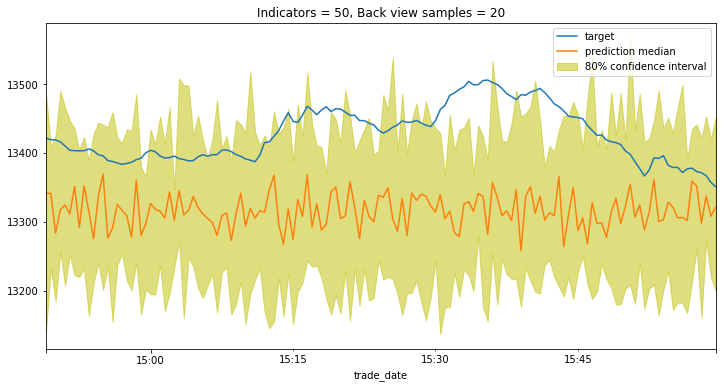

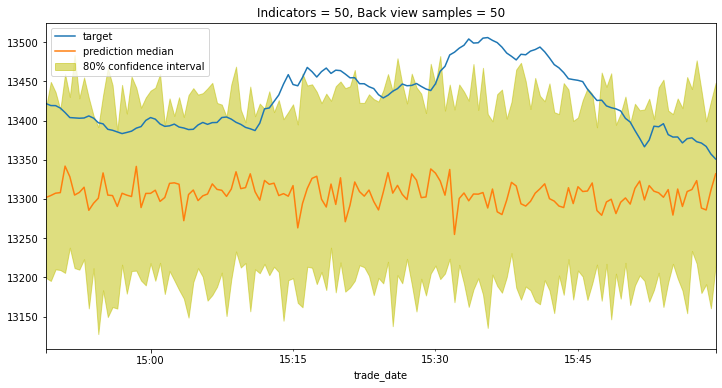

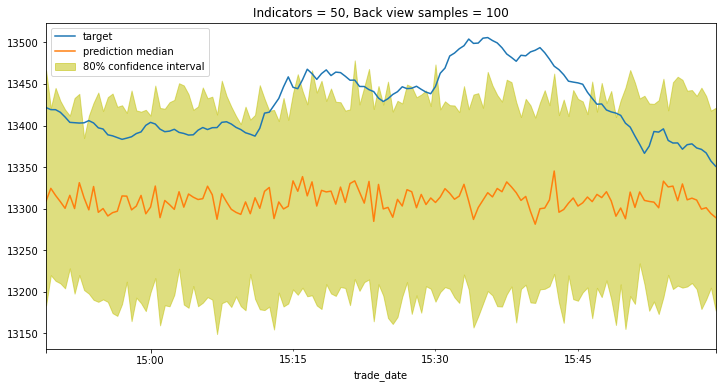

In [66]:
# 50
draw_line()

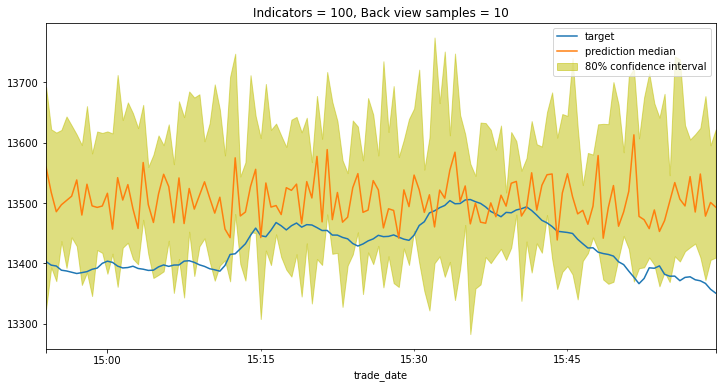

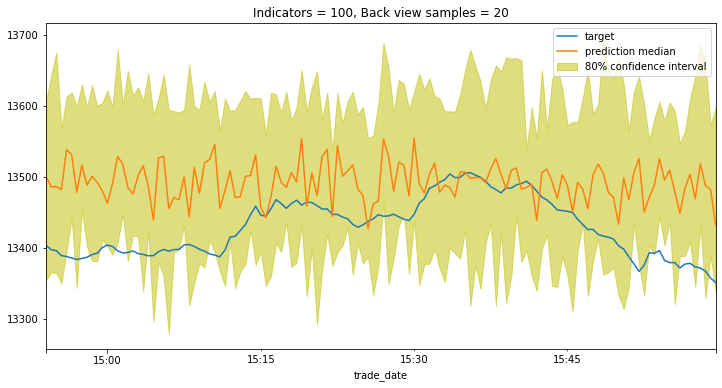

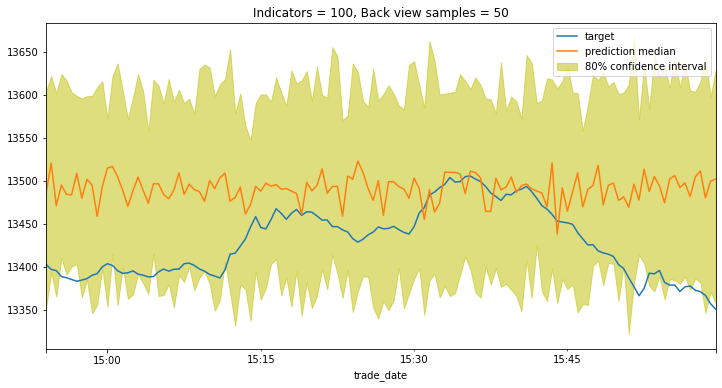

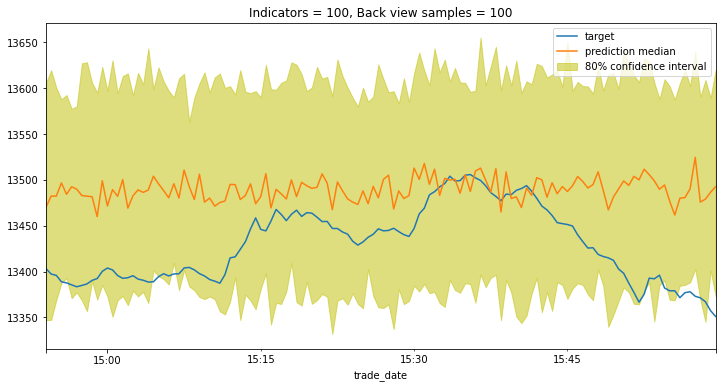

In [85]:
# 100
draw_line()

### Delete endpoint

In [86]:
sm_session.delete_endpoint(endpoint_name)

In [87]:
predictor.delete_endpoint()

ClientError: An error occurred (ValidationException) when calling the DescribeEndpoint operation: Could not find endpoint "arn:aws:sagemaker:us-east-1:499362316899:endpoint/aapl-deepar-2022-04-30-02-04-29-536".